# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify ~~all symbols~~ letters a -> g

### Subset the data

Select only the lowercase letters (a, b, ..., g) for classification

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 3. Model showdown: upper vs lowercase on abcXYZ

### Subset the data

Select out the set of upper- and lowercase (a, b, c, x, y z, A, B, C, X, Y, Z). Note that some of these classes can be confusing (e.g., x and y).

### Train and tune models

Perform a full model training and hyperparameter tuning.

1. Select candidate models, hyperparameter options, and evaluation metric
2. Set aside a validation hold-out dataset
3. Train models over K splits (use k-fold or train/test split)
    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
    2. Train on k-fold split
    3. Record performance of each set of parameters
    4. Use winning set of parameters to train model on full training set
    5. Record each model's performance on that split's test set
4. Evaluate model performance and promote one model as the winner
5. Train winning model on both train + test
6. Check model performance on the validation hold-out


## 4. (_Optional_) Model comparison: classify even vs odd

**NOTE:** This is a larger dataset (~400k rows) so it will require more memory and time to train models on it. 

Alternatively, you can train models on smaller subsets of the data to get a feel for which models perform better than others. Then train the winning model on the full dataset and validate against the hold-out.

### Subset the data

Select only digits and add a column for 'is_even'. Be sure to create a validation hold-out dataset for later.

### Build and compare models

Train at least two different models, compare the results and choose a winner based on an evaluation metric of your choice.

In [1]:
%pip install -q emnist pandas pyarrow numpy matplotlib seaborn scikit-learn xgboost tensorflow
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown


# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from itertools import product


# ML packages
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier

# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings

In [3]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)


def display_metrics_cm(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['first letter', 'second letter', 'Other'], columns=['first letter', 'second letter', 'Other'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)


In [4]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
emnist_train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
emnist_train['image'] = list(image)
emnist_train['image_flat'] = emnist_train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
emnist_train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
emnist_train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
emnist_test = pd.DataFrame()
emnist_test['image'] = list(image)
emnist_test['image_flat'] = emnist_test['image'].apply(lambda x: np.array(x).reshape(-1))
emnist_test['label'] = label
emnist_test['class'] = class_label

# Combine the training and test splits
emnist_all = pd.concat([emnist_train, emnist_test], axis=0)

# Subset for only digits 0-9
digits = emnist_all[emnist_all['label'] < 10]

# Subset for lowercase letters
lowercase = emnist_all[(emnist_all['class'] >= 'a') & (emnist_all['class'] <= 'z')]
uppercase = emnist_all[(emnist_all['class'] >= 'A') & (emnist_all['class'] <= 'Z')]

# Subset for upper- and lowercase letters a, b, c, d, e, f, g
a2g = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g']))]

# Subset for upper- and lowercase letters a, b, c, x, y, z
abcxyz = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'A', 'B', 'C', \
                                               'x', 'y', 'z', 'X', 'Y', 'Z']))]

In [5]:
# Display the size of a2g, abcxyz, digits, and the full dataset
display(Markdown(f'# Dataset Sizes'))
display(Markdown(f'**a2g**: {len(a2g)}'))
display(Markdown(f'**abcxyz**: {len(abcxyz)}'))
display(Markdown(f'**digits**: {len(digits)}'))
display(Markdown(f'**emnist_all**: {len(emnist_all)}'))

# Dataset Sizes

**a2g**: 68795

**abcxyz**: 65926

**digits**: 402953

**emnist_all**: 814255

In [6]:
# FIXME: Classify lettters as uppercase/lowercase
abcxyz['is_upper'] = abcxyz['class'].isin(['A','B','C','X','Y','Z'])

# FIXME: Classify digits as even/odd
digits['is_even'] = digits['class'].astype(int)%2==0

/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 2. Classify  a -> g

### Subset the data

Select only the lowercase letters (a, b, ..., g) for classification

In [7]:
len(lowercase)

190998

In [8]:
# For a preliminary analysis, sample 10%
lowercase_subset = lowercase.sample(n= 19000, replace=False, random_state=42)

In [9]:
# If use all data
# lowercase_subset = lowercase

In [10]:
X = lowercase_subset.drop('label',axis=1)
y = lowercase_subset.label

In [11]:
# Hold out the validationset
X_train, X_val, y_train,y_val = train_test_split(X, y, test_size= 0.3, random_state=42, stratify=y)

In [12]:
# Check the size of each dataset
print("Training set size:", X_train.shape[0])
print("Test set size:", X_val.shape[0])

Training set size: 13300
Test set size: 5700


In [13]:
# Replace the value so that the target starts at 0 (Original data-> 0-9: number, 10-35: large letters, 36-61)
y_train = y_train-36
y_val = y_val-36

### Choose a model : XGBoost

### Train and Evaluate the model

In [14]:
# All symbols classifier: XGBoost
task = 'the lowercase letters'
model_name = 'xgboost'

# Initializa XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate the model
xgb_clf.fit(X_train['image_flat'].tolist(), y_train)
y_pred = xgb_clf.predict(X_val['image_flat'].tolist())

In [15]:
# Calculate performance metrics
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred,average='weighted',zero_division=0)
rec = recall_score(y_val, y_pred,average='weighted',zero_division=0)
f1 = f1_score(y_val, y_pred,average='weighted',zero_division=0)
cm = confusion_matrix(y_val, y_pred)

In [16]:
metrics_dict = {
    'the lowercase letters': {
        'xgboost': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [17]:
# Store the results to metrics_dict
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  }

In [18]:
# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.87,0.86666,0.87,0.866288


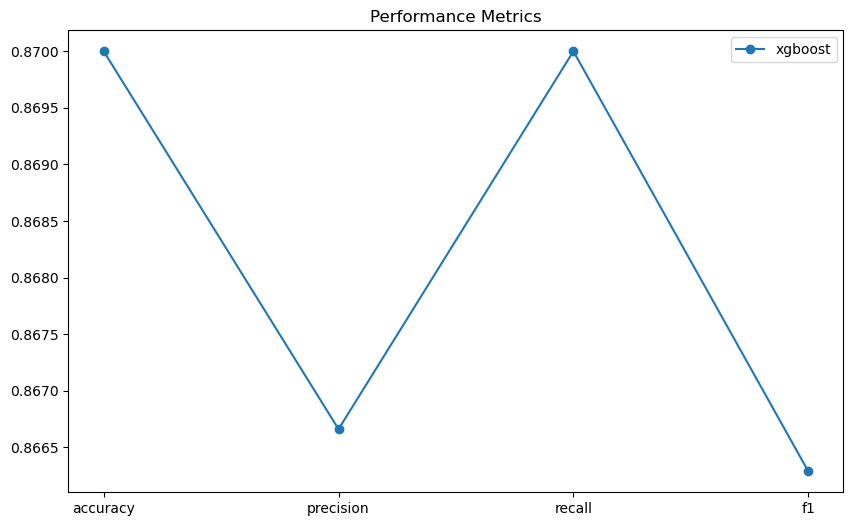

In [19]:
# Visualise the performance
colors = ['#1f77b4']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['the lowercase letters'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['the lowercase letters'][model][label] for label in labels]

    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])


# add a legend and title
ax.legend()
ax.set_title('Performance Metrics')

# show the plot
plt.show()

### Investigate subsets


In [20]:
# Investigate subsets
# Make subsets
## i and j
symbols_list = ['i', 'j']
mask_valid = X_val['class'].apply(lambda x: x in symbols_list)
valid_01_X = X_val[mask_valid]
valid_01_y = y_val[mask_valid]
valid_01_X.reset_index(drop=True, inplace=True)

## m and n
symbols_list = ['m', 'n']
mask_valid = X_val['class'].apply(lambda x: x in symbols_list)
valid_02_X = X_val[mask_valid]
valid_02_y = y_val[mask_valid]
valid_02_X.reset_index(drop=True, inplace=True)

## u and v
symbols_list = ['u', 'v']
mask_valid = X_val['class'].apply(lambda x: x in symbols_list)
valid_03_X = X_val[mask_valid]
valid_03_y = y_val[mask_valid]
valid_03_X.reset_index(drop=True, inplace=True)



In [21]:
metrics_dict_subsets = {
    'Investigate_subsets_using_xgboost' : { # task name (Investigate_subsets_using_xgboost)
        'i vs j': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'confusion matrix': []
        },
        'm vs n': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'confusion matrix': []
        },
        'u vs v': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'confusion matrix': []
        }
    }
}

In [22]:
metrics_dict_subsets

{'Investigate_subsets_using_xgboost': {'i vs j': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': [],
   'confusion matrix': []},
  'm vs n': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': [],
   'confusion matrix': []},
  'u vs v': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': [],
   'confusion matrix': []}}}

In [23]:
# All symbols classifier: XGBoost
task = 'Investigate_subsets_using_xgboost'

y_pred_01 = xgb_clf.predict(valid_01_X['image_flat'].tolist())
y_pred_02 = xgb_clf.predict(valid_02_X['image_flat'].tolist())
y_pred_03 = xgb_clf.predict(valid_03_X['image_flat'].tolist())

# i vs j
## Calculate performance metrics
model_name = 'i vs j'
acc = accuracy_score(valid_01_y, y_pred_01)
prec = precision_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
rec = recall_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
f1 = f1_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)

unique = np.unique(valid_01_y)
y_pred_01_replaced = np.where(np.isin(y_pred_01, unique), y_pred_01, "Other")

# Label array to create a confusion matrix
# Get unique values from valid_01_y and convert to string type
unique_str = unique.astype(str)
# Create a list of labels containing 'other
labels = np.concatenate((unique_str, ['Other']))

# Make a confusion matrix
cm1 = confusion_matrix(valid_01_y.astype(str), y_pred_01_replaced, labels= labels)

## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 'confusion matrix': cm1
                                 }
# Display performance metrics
display_metrics_cm(task, model_name, metrics_dict_subsets)

# m vs n
## Calculate performance metrics
model_name = 'm vs n'
acc = accuracy_score(valid_02_y, y_pred_02)
prec = precision_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)
rec = recall_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)
f1 = f1_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)

unique = np.unique(valid_02_y)
y_pred_02_replaced = np.where(np.isin(y_pred_02, unique), y_pred_02, "Other")

# Label array to create a confusion matrix
# Get unique values from valid_01_y and convert to string type
unique_str = unique.astype(str)
# Create a list of labels containing 'other
labels = np.concatenate((unique_str, ['Other']))

# Make a confusion matrix
cm2 = confusion_matrix(valid_02_y.astype(str), y_pred_02_replaced, labels= labels)


## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 'confusion matrix': cm2
                                 }
# Display performance metrics
display_metrics_cm(task, model_name, metrics_dict_subsets)

# u vs v
## Calculate performance metrics
model_name = 'u vs v'
acc = accuracy_score(valid_03_y, y_pred_03)
prec = precision_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)
rec = recall_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)
f1 = f1_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)

unique = np.unique(valid_03_y)
y_pred_03_replaced = np.where(np.isin(y_pred_03, unique), y_pred_03, "Other")

# Label array to create a confusion matrix
# Get unique values from valid_01_y and convert to string type
unique_str = unique.astype(str)
# Create a list of labels containing 'other
labels = np.concatenate((unique_str, ['Other']))

# Make a confusion matrix
cm3 = confusion_matrix(valid_03_y.astype(str), y_pred_03_replaced, labels= labels)


## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 'confusion matrix': cm3
                                 }

# Display performance metrics
display_metrics_cm(task, model_name, metrics_dict_subsets)

# Performance Metrics: i vs j

,accuracy,precision,recall,f1
0,0.530488,0.908088,0.530488,0.657275


# Confusion Matrix: i vs j

,first letter,second letter,Other
first letter,39,3,57
second letter,5,48,12
Other,0,0,0


# Performance Metrics: m vs n

,accuracy,precision,recall,f1
0,0.913127,0.981254,0.913127,0.945764


# Confusion Matrix: m vs n

,first letter,second letter,Other
first letter,81,7,7
second letter,2,392,29
Other,0,0,0


# Performance Metrics: u vs v

,accuracy,precision,recall,f1
0,0.759162,0.955311,0.759162,0.844534


# Confusion Matrix: u vs v

,first letter,second letter,Other
first letter,68,5,23
second letter,2,77,16
Other,0,0,0



### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

In [24]:
# 1. Select candidate models, hyperparameter options, and evaluation metric
xgb_param_grid = {
    'n_estimators': [100,200],
    'learning_rate': [0.05,0.1],
    'max_depth': [3,5],
    'min_child_weight': [2,3],
    'subsample': [0.8,1.0]
}
scoring_metric = 'f1'

In [25]:
# Define how many folds you want to split on
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [26]:
# Set a model
# Initialize best score and best model
models = [
    (XGBClassifier(), xgb_param_grid)
]

best_score = 0
best_model = None

In [27]:
for model, param_grid in models:
     for param_combination in product(*param_grid.values()):
         param_dict = dict(zip(param_grid.keys(), param_combination))
         model.set_params(**param_dict)
         fold_scores = []

         # 3.A. Split train using k-fold with the number of folds
         # equal to the number of parameter combinations
         for train_index, test_index in kf.split(X_train):
             X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
             y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

             # 3.B. Train on k-fold split
             model.fit(X_fold_train['image_flat'].tolist(), y_fold_train)
             # 3.C. Record performance of each set of parameters
             y_pred = model.predict(X_fold_test['image_flat'].tolist())
             fold_score = accuracy_score(y_fold_test, y_pred)
             fold_scores.append(fold_score)

         # 3.D. Use the winning set of parameters to train the model on the full training set
         avg_score = np.mean(fold_scores)
         if avg_score > best_score:
             best_score = avg_score
             best_model = model

# Print the best model
print("Best Model:", best_model)

Best Model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [28]:
# Train the best model with the all train dataset
best_model.fit(X_train['image_flat'].tolist(), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [29]:
# Evaluate the best model with the hold-out validation set
y_val_pred = best_model.predict(X_val['image_flat'].tolist())
validation_score = accuracy_score(y_val, y_val_pred)

In [30]:
validation_score

0.8705263157894737

## 3. Model showdown: upper vs lowercase on abcXYZ

### Subset the data

Select out the set of upper- and lowercase (a, b, c, x, y z, A, B, C, X, Y, Z). Note that some of these classes can be confusing (e.g., x and y).


In [31]:
# Target: is_upper, features: image_flat
abcxyz.head(5)

,image,image_flat,label,class,is_upper
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,True
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,False
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,False
40,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,C,True
43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",59,x,False


### Train and tune models

Perform a full model training and hyperparameter tuning.

1. Select candidate models, hyperparameter options, and evaluation metric
2. Set aside a validation hold-out dataset
3. Train models over K splits (use k-fold or train/test split)
    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
    2. Train on k-fold split
    3. Record performance of each set of parameters
    4. Use winning set of parameters to train model on full training set
    5. Record each model's performance on that split's test set
4. Evaluate model performance and promote one model as the winner
5. Train winning model on both train + test
6. Check model performance on the validation hold-out


In [48]:
# 1. Select candidate models, hyperparameter options, and evaluation metric

param_grid = {
    'n_estimators': [100,200],
    'learning_rate': [0.05,0.1],
    'max_depth': [3,5],
    'min_child_weight': [2,3],
    'subsample': [0.8,1.0],
    'random_state' : [42]
}


lr_param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [500, 1000],
    'solver':['saga'],
    'random_state' : [42]
}


scoring_metric = 'f1'

In [49]:
# 2. Set aside a validation hold-out dataset
X = abcxyz.drop('is_upper',axis=1)
y = abcxyz.is_upper

X_train, X_val, y_train,y_val = train_test_split(X, y, test_size= 0.3, random_state=42, stratify=y)

In [50]:
#3. Train models over K splits (use k-fold or train/test split)
#    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
#    2. Train on k-fold split
#    3. Record performance of each set of parameters
#    4. Use winning set of parameters to train model on full training set
#    5. Record each model's performance on that split's test set

# Set models
models = [
    (XGBClassifier(), xgb_param_grid),
    (LogisticRegression(), lr_param_grid)

]

# Initialize best score and best model
best_score = 0
best_model = None

scaler = StandardScaler()

for model, param_grid in models:
    
    for param_combination in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), param_combination))
        model.set_params(**param_dict)
        fold_scores = []
        
        for train_index, test_index in kf.split(X_train):
            # Check model type and apply scaling if needed
            if isinstance(model, LogisticRegression):
                # Scaling the datasets for the logistic regression
                X_fold_train_scaled = scaler.fit_transform(X_train.iloc[train_index]['image_flat'].tolist())
                X_fold_test_scaled = scaler.transform(X_train.iloc[test_index]['image_flat'].tolist())
                X_fold_train_use, X_fold_test_use = X_fold_train_scaled, X_fold_test_scaled
            else:
                X_fold_train_use = X_train.iloc[train_index]['image_flat'].tolist()
                X_fold_test_use = X_train.iloc[test_index]['image_flat'].tolist()
                
            y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

            # Train on k-fold split
            model.fit(X_fold_train_use, y_fold_train)
            
            # Record performance of each set of parameters
            y_pred = model.predict(X_fold_test_use)
            fold_score = accuracy_score(y_fold_test, y_pred)
            fold_scores.append(fold_score)

        # Use the winning set of parameters to train the model on the full training set
        avg_score = np.mean(fold_scores)
        if avg_score > best_score:
            best_score = avg_score
            best_model = model

# Print the best model
print("Best Model:", best_model)

/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The ma

Best Model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [51]:
print(f"Best Model Parameters: {best_model}")
print(f"Best Model Average Cross-Validation Score: {best_score}")

Best Model Parameters: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Best Model Average Cross-Validation Score: 0.8412282014311369


In [52]:
# 4. Use winning set of parameters to train model on full training set
best_model.fit(X_train['image_flat'].tolist(), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [53]:
# 5. Record each model's performance on that split's test set
y_val_pred = best_model.predict(X_val['image_flat'].tolist())
validation_score = accuracy_score(y_val, y_val_pred)

In [54]:
validation_score

0.8434118717767216